In [1]:
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import copy

from matplotlib import style
style.use('seaborn')

In [3]:
random.seed(4)

In [4]:
def exprand(lambdr):
    return np.random.exponential(1/lambdr)

print(exprand(1/5))
print(np.random.exponential(5))

2.1860327814993354
5.05679367783223


In [5]:
a = []
b = []
for i in range(100000):
    a.append(np.random.exponential(5))
    b.append(exprand(1/5))
print(statistics.mean(a))
print(statistics.mean(b))

4.982673268906889
5.0014558316901


In [15]:
class Customer:
    def __init__(self, customer_id, check_in_time, time_to_process_this_customer):
        self.customer_id = customer_id  # номер человека
        self.check_in_time = check_in_time #время, в которое он придет
        self.time_to_process_this_customer = time_to_process_this_customer # время на обработку этого человека (+1 временное решение того, что 0 требуется на процесс)
        self.spent_time=time_to_process_this_customer
        
    def __repr__(self):
        return f'id={self.customer_id}, check_in= {self.check_in_time}, time_to_process_this_customer= {self.time_to_process_this_customer}'

# Обработчик
class Handler:
    def __init__(self, id):
        self.id = id
        self.powerness = 1.0
        self.tmp_powerness = self.powerness
        self.customer = None

    def process_customer(self, customer):
        self.customer.time_to_process_this_customer -= self.tmp_powerness
        if self.customer.time_to_process_this_customer <= 0:
            self.tmp_powerness = -self.customer.time_to_process_this_customer
    
    def process_own_customer(self, mean_time_spent):
        if self.customer:
            self.process_customer(self.customer)
            if self.customer.time_to_process_this_customer <= 0:
                mean_time_spent.append(self.customer.spent_time)
                self.customer = None
                
    def process_customers(self, list_of_customers, mean_time_spent):  
        self.process_own_customer(mean_time_spent)
        while not self.customer and self.tmp_powerness > 0 and list_of_customers:
            self.customer = list_of_customers.pop(0)
            self.process_own_customer(mean_time_spent)
            if self.customer:
                break
        self.tmp_powerness = self.powerness
                    
    def get_tmp_powerness(self):
        return self.tmp_powerness
    
    def get_powerness(self):
        return self.powerness

In [25]:
# Вeликий обрабатор!
class MainHandler:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        #self.number_of_customers = number_of_customers
        self.list_of_customers = []
        self.list_of_tmp_customers = []
        self.list_of_handlers = []
        self.number_of_customers_left  = 0
        self.number_of_customers_handle  = 0
        self.customers_growth = []
        self.customers_all = 0
        self.mean_time_spent = []
        self.handler_load = []
        self.lambda_ = lambda_
        self.nu = nu
        
    def get_next(self, customer_id, check_in, nu):
        # Устанавливаем номер человека
        # время, через котрое он придет
        # и время, которое требуется на его обработку
        customer = Customer(customer_id, check_in, abs(exprand(nu)))
    
        return customer
    
    def generate_customers(self, steps):
        lost_time = steps  # оставшееся количество шагов == время для генерации

        customer_id = 0
        
        for i in range(steps):
            tmp = round(exprand(self.lambda_))
            '''print(tmp)'''
            if tmp == 0:
                tmp = 1
            
            for j in range(tmp):
                customer = self.get_next(customer_id, i, self.nu)
                '''print(customer)'''
                customer_id += 1
                self.list_of_customers.append(customer)

        #print("Number of customers:" + str(len(self.list_of_customers)))
        #for customer in self.list_of_customers:
            #print("check_in_time: "+str(customer.check_in_time) + " and time_to_process_this_customer:" + str(customer.time_to_process_this_customer))

    def start(self, steps):
        self.generate_customers(steps)
        
        for i in range(self.number_of_handlers):
            self.list_of_handlers.append(Handler(i))

        for i in range(steps):
            new_customers = [customer for customer in self.list_of_customers if customer.check_in_time == i]
            
            # save customers number
            self.customers_all += len(new_customers)
            self.customers_growth.append(self.customers_all)
            self.number_of_customers_handle+=len(new_customers)
            
            # обрабатываем людей
            for handler in self.list_of_handlers:
                handler.process_customers(new_customers, self.mean_time_spent)
        
            number_of_working_handlers = 0
            for handler in self.list_of_handlers:
                if handler.customer:
                    number_of_working_handlers += 1
            
            self.handler_load.append(number_of_working_handlers)
            
            self.number_of_customers_left+=len(new_customers)
            
            self.number_of_customers_handle-=len(new_customers)
                
            # продолжаем

    def clear(self):
        self.list_of_customers.clear()
        self.list_of_handlers.clear()
        self.number_of_customers_left  = 0
        self.customers_growth.clear()
        self.customers_all = 0
        self.mean_time_spent.clear()
        self.handler_load.clear()
        
    # statistics
    def get_customers(self):
        return self.list_of_customers
    
    # количество пришедших кастомеров с начала
    def get_customer_growth(self):
        return self.customers_growth
    
    # Среднее количество НОВЫХ заявок в системе
    def get_mean_customer_growth(self):
        return self.customers_all/len(self.customers_growth)
    
    # количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_handler_load(self):
        return self.handler_load
    
    # Среднее количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_mean_handler_load(self):
        sum_load = 0
        for load in self.handler_load:
            sum_load += load
        
        return sum_load/len(self.handler_load)
    
    # среднее время пребыания?
    def get_mean_time_spent(self):
        return statistics.mean(self.mean_time_spent)
    
    # вероятность отказа
    def get_deny_probability(self):
        return self.number_of_customers_left/self.customers_all

In [17]:
class Model:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.__handler = MainHandler(number_of_handlers, 1/lambda_, nu)
        self.__time = None
        
    def run(self):
        if self.__time is None or self.__handler is None:
            raise ValueError
        
        self.__handler.start(self.__time)
        
    def set_time(self, time):
        if time <= 0:
            raise ValueError
            
        self.__time = time
        
    def get_time(self):
        return self.__time
    
    def get_handler(self):
        return self.__handler
    
    def set_handler(self, handler):
        self.__handler = handler
    
    handler = property(get_handler, set_handler)
    time = property(get_time, set_time)


In [9]:
# Устанавливаем параметры
'''lambda_ = 1 # интенсивность
nu = 5 #пропускная способность
number_of_handlers = 5 # кол-во обработчиков
random.seed(42)

NUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'''




'lambda_ = 1 # интенсивность\nnu = 5 #пропускная способность\nnumber_of_handlers = 5 # кол-во обработчиков\nrandom.seed(42)\n\nNUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'

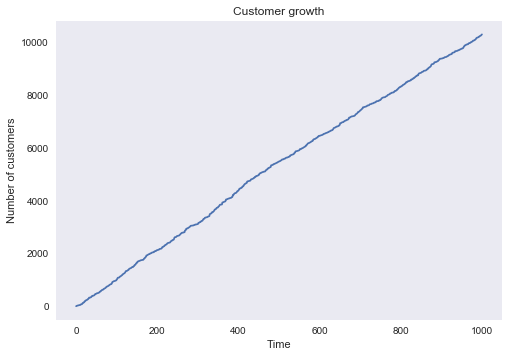

In [710]:
import matplotlib

customers = model.handler.get_customer_growth()

# Data for plotting
x = customers

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Number of customers',
       title='Customer growth')
ax.grid()

# fig.savefig("Customer_growth.png")
plt.show()

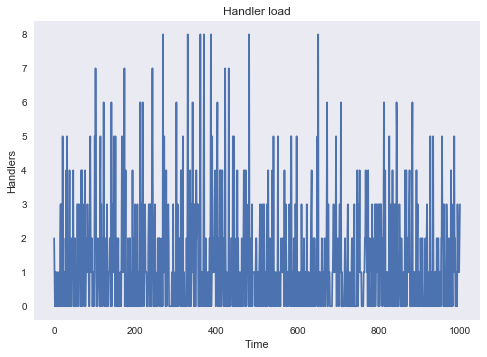

In [713]:
import matplotlib

load = model.handler.get_handler_load()

# Data for plotting
x = load


fig, ax = plt.subplots()

ax.plot(x)

ax.set(xlabel='Time', ylabel='Handlers',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

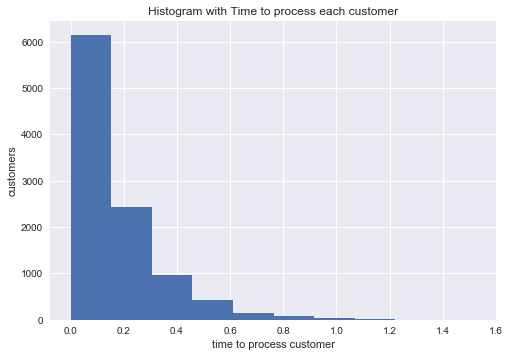

In [714]:
x = model.handler.mean_time_spent

# the histogram of the data
n, bins, patches = plt.hist(x)


plt.xlabel('time to process customer')
plt.ylabel('customers')
plt.title('Histogram with Time to process each customer')

plt.grid(True)
plt.show()

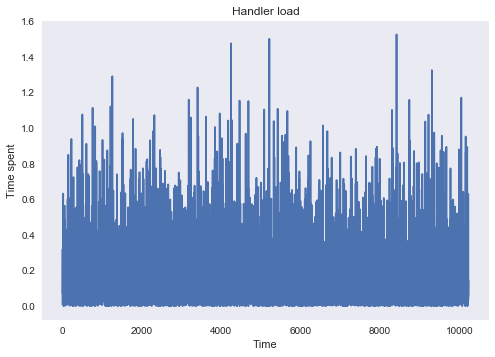

In [715]:
import matplotlib

load = model.handler.mean_time_spent

# Data for plotting
x = load


fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Time spent',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

In [29]:
class Theory:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        self.lambda_ = lambda_
        self.nu = nu

# вероятность, что k обработчиков заняты
    def get_k_handlers_load_probability(self, k):
        summa = 0
        
        if k == 0:
            return 1 - sum([self.get_k_handlers_load_probability(a) for a in range(1, self.number_of_handlers+1)])
        for i in range(0, self.number_of_handlers + 1):
            summa += pow(self.lambda_, i) / (math.factorial(i) * pow(self.nu, i))
        
        return pow(self.lambda_, k) / (math.factorial(k) * pow(self.nu, k) * summa)

# вероятность отказа
    def get_loss_probability(self):
        return self.get_k_handlers_load_probability(self.number_of_handlers)

# относительная пропускная способность - вероятность, что заявка будет обслужена
    def get_handle_probability(self):
        return 1 - self.get_loss_probability()

# среднее время поступления заявки
    def get_mean_waiting_time(self):
        return self.lambda_

# среднее время обслуживания
    def get_mean_time_spent(self):
        return 1 / self.nu

# абсолютная пропускная способность - среднее число заявок, обслуживаемых в единицу времени
    def absolute_bandwidth(self):
        return self.lambda_ * self.get_handle_probability()

# число покупалетей за все время
    def get_customers_all(self, steps):
        return self.lambda_ * steps

# среднее число занятых касс - интенсивность потока обслуженных системой заявок (в единицу времени)
    def get_mean_handler_load(self):
        a = 0
        for n in range(0, self.number_of_handlers):
            a += n * self.get_k_handlers_load_probability(n)
        return a
#        return absolute_bandwidth() / self.nu

    def get_number_of_customers_left(self, steps):
        return self.get_customers_all(steps) * self.get_loss_probability()
    
    def get_number_of_customers_handle(self, steps):
        return self.get_customers_all(steps) * self.get_handle_probability()

In [31]:
steps=1000
lam_=14
nu_=3
num_hand=6
model = Model(num_hand, lam_, nu_)
theory = Theory(num_hand, lam_, nu_)
model.time = steps
model.run()
print(model.handler.get_deny_probability())
print(theory.get_loss_probability())

0.2161045594531661
0.16671939427842233


In [32]:
print(model.handler.number_of_customers_handle)
print(theory.get_number_of_customers_handle(steps))

10436
11665.928480102088


In [33]:
print(model.handler.get_mean_handler_load())
print(theory.get_mean_handler_load())

2.945
2.8883264610301618


In [34]:
print(model.handler.customers_all)
print(model.handler.number_of_customers_left)
print(theory.get_customers_all(steps))
print(theory.get_number_of_customers_left(steps))

13313
2877
14000
2334.071519897913


In [35]:
print(model.handler.get_mean_customer_growth())
print(theory.get_mean_waiting_time())

13.313
14


In [36]:
print(model.handler.get_mean_time_spent())
print(theory.get_mean_time_spent())

0.3321594172778213
0.3333333333333333


In [37]:
print(model.handler.get_mean_handler_load())
print(theory.get_mean_handler_load())

2.945
2.8883264610301618


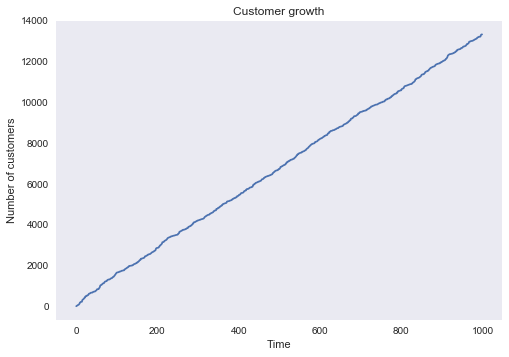

In [38]:
import matplotlib

customers = model.handler.get_customer_growth()

# Data for plotting
x = customers

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Number of customers',
       title='Customer growth')
ax.grid()

# fig.savefig("Customer_growth.png")
plt.show()

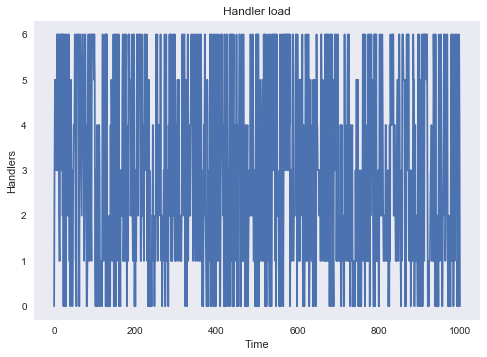

In [39]:
import matplotlib

load = model.handler.get_handler_load()

# Data for plotting
x = load


fig, ax = plt.subplots()

ax.plot(x)

ax.set(xlabel='Time', ylabel='Handlers',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

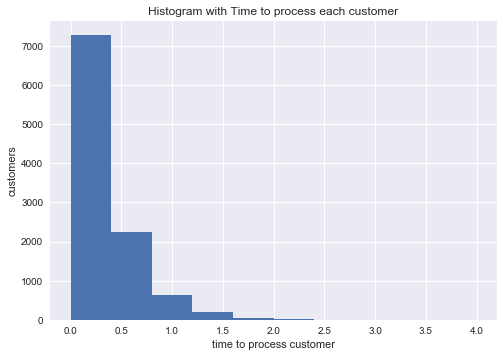

In [40]:
x = model.handler.mean_time_spent

# the histogram of the data
n, bins, patches = plt.hist(x)


plt.xlabel('time to process customer')
plt.ylabel('customers')
plt.title('Histogram with Time to process each customer')

plt.grid(True)
plt.show()

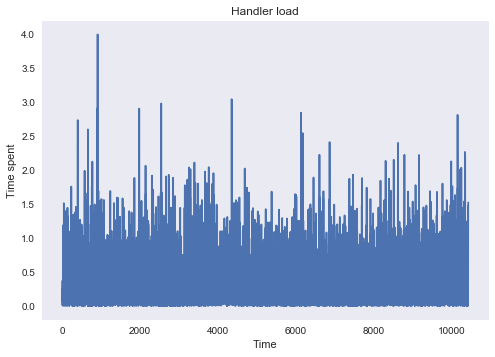

In [41]:
import matplotlib

load = model.handler.mean_time_spent

# Data for plotting
x = load


fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Time spent',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()